In [21]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np 
import math
from scipy import interpolate
from scipy.signal import savgol_filter
import csv
import os
from datetime import datetime
import sys

sys.path.append(os.path.join(os.getcwd(), "..", ".."))
from support.omniwheel_calculation import *
from datetime import datetime
from support.pd_support import *
from support.calculations_support import *
from support.ar_calculations import *
import polars as pl
from tqdm import tqdm

In [22]:
_parent_folder = "omni_9dof_feb_28_2023"
_folder_name = "sk27_00_random_slow"
_base_pth = os.path.dirname(os.getcwd())
_base_pth = os.path.join(_base_pth, "..","recording_programs", "test_data", _parent_folder)
_base_pth
_sk_df = pd.read_csv(os.path.join(_base_pth, _folder_name, "imu_df.csv"))
_sk_df["time"] = _sk_df["time"].apply(lambda x: datetime.fromtimestamp(x))



In [23]:
def quaternion_multiply(quaternion1, quaternion0):
    w0, x0, y0, z0 = quaternion0
    w1, x1, y1, z1 = quaternion1
    return np.array([-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
                     x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
                     -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
                     x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0], dtype=np.float64)

In [30]:
def validation(df):
    # columns =['gyrox1','gyroy1','gyroz1','accelx1','accely1','accelz1','Time']
    # df = pd.read_csv(imu_file, usecols=columns)

    _acceleration_filter_window = 101
    _acceleration_filter_order = 9
    _gyro_filter_window = 81
    _gyro_filter_order = 9

    df.ax = savgol_filter(df.ax, _acceleration_filter_window, _acceleration_filter_order)
    df.ay = savgol_filter(df.ay, _acceleration_filter_window, _acceleration_filter_order)
    df.az = savgol_filter(df.az, _acceleration_filter_window, _acceleration_filter_order)
    df.gx = savgol_filter(df.gx, _gyro_filter_window, _gyro_filter_order)
    df.gy = savgol_filter(df.gy, _gyro_filter_window, _gyro_filter_order)
    df.gz = savgol_filter(df.gz, _gyro_filter_window, _gyro_filter_order)

    _gx_offset = df.gx[:100].mean()
    _gy_offset = df.gy[:100].mean()
    _gz_offset = df.gz[:100].mean()


    q4=[]
    Q1=[]
    accx1=df.ax
    accy1=df.ay
    accz1=df.az
    angx=np.deg2rad(df.gx- _gx_offset) 
    angy=np.deg2rad(df.gy- _gy_offset) 
    angz=np.deg2rad(df.gz- _gz_offset) 

    ang_comp=[]
    a=0.02
    for j in range(len(angx)):
        norm=np.linalg.norm([angx[j],angy[j],angz[j]]) 
        axis_of_rot=[angx[j]/norm,angy[j]/norm,angz[j]/norm]
        theta= 0.01*norm
        q0=math.cos(theta/2)
        q1=(axis_of_rot[0])*math.sin(theta/2)
        q2=(axis_of_rot[1])*math.sin(theta/2)
        q3=(axis_of_rot[2])*math.sin(theta/2)
        q_comp=[q0,q1,q2,q3]
        Q=[0,accx1[j],accy1[j],accz1[j]]
        Q1.append(Q)
        q4.append(q_comp)
    s_comp=q4[0]
    for j in range(len(q4)):
        dummy=s_comp
        normq5=((dummy[0]*dummy[0])+(dummy[1]*dummy[1])+(dummy[2]*dummy[2])+(dummy[3]*dummy[3]))
        invq51=[s_comp[0]/normq5,s_comp[1]/normq5,s_comp[2]/normq5,s_comp[3]/normq5]
        invq5=[invq51[0],-1*invq51[1],-1*invq51[2],-1*invq51[3]]
        qupdat1=quaternion_multiply(s_comp,Q1[j])
        qupdate=quaternion_multiply(qupdat1,invq5)
        norm1=np.sqrt((qupdate[0]*qupdate[0])+(qupdate[1]*qupdate[1])+(qupdate[2]*qupdate[2])+(qupdate[3]*qupdate[3]))
        init=Q1[0][1:]
        new_qup=[qupdate[0]/norm1,qupdate[1]/norm1,qupdate[2]/norm1,qupdate[3]/norm1]
        rot_ax=np.cross(new_qup[1:],init)
        norm=np.linalg.norm(rot_ax)
        axis_of_rot=rot_ax/norm
        thet=(np.dot(new_qup[1:],init))/((np.linalg.norm(new_qup[1:])*np.linalg.norm(init)))
        theta=np.arccos(thet)
        q0=math.cos(a*theta/2)
        q1=(axis_of_rot[0])*math.sin(a*theta/2)
        q2=(axis_of_rot[1])*math.sin(a*theta/2)
        q3=(axis_of_rot[2])*math.sin(a*theta/2)
        qt=[q0,q1,q2,q3]
        s=quaternion_multiply(s_comp,q4[j])
        s_comp=quaternion_multiply(qt,s)
        finaltheta=np.rad2deg(2*np.arccos(s_comp[0]))
        ang_comp.append(finaltheta)
    
    IMU=ang_comp
    return IMU

In [31]:
_imu =  validation(_sk_df)

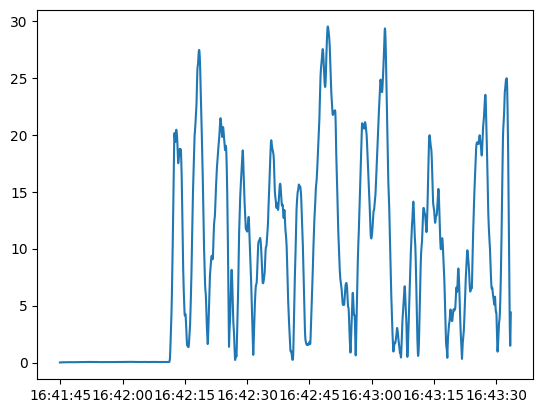

In [26]:
plt.plot(_sk_df.time[:10000], _imu[:10000])

In [27]:
# type in marker details
_xm = get_marker_name(2)
_ym = get_marker_name(1)
_om = get_marker_name(3)

# mocap data
_mocap_df, st_time = read_rigid_body_csv(os.path.join(_base_pth, _folder_name.split("_")[0] ,_folder_name + ".csv"))
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")
_mocap_df.time

0       2023-02-28 16:41:55.054
1       2023-02-28 16:41:55.064
2       2023-02-28 16:41:55.074
3       2023-02-28 16:41:55.084
4       2023-02-28 16:41:55.094
                  ...          
61954   2023-02-28 16:52:14.594
61955   2023-02-28 16:52:14.604
61956   2023-02-28 16:52:14.614
61957   2023-02-28 16:52:14.624
61958   2023-02-28 16:52:14.634
Name: time, Length: 61959, dtype: datetime64[ns]

In [28]:
_m_df = _mocap_df.copy()
_m_df = pl.from_pandas(_m_df)

_rotmat_i = []
for i in tqdm(range(len(_m_df))):
    
    _x_vec = _m_df[[_xm["x"], _xm["y"], _xm["z"]]][i, :].to_numpy().T
    _org = _m_df[[_om["x"], _om["y"], _om["z"]]][i, :].to_numpy().T
    _y_vec = _m_df[[_ym["x"], _ym["y"], _ym["z"]]][i, :].to_numpy().T

    _rotmat_i.append(calculate_rotmat_from_xyo(_x_vec, _y_vec, _org))
# calculating del rotmat for mc
_del_r = []
for i in tqdm(range(len(_rotmat_i))):
    _del_r.append(_rotmat_i[i].T@_rotmat_i[0])

# calculating angle for mc
_theta_x = []
_theta_y = []
_theta_z = []

for i in tqdm(_del_r):
    _theta_x.append(np.arctan2(i[2,1], i[2,2]))
    _theta_y.append(np.arctan2(-i[2,0], np.sqrt(i[2,1]**2 + i[2,2]**2)))
    _theta_z.append(np.arctan2(i[1,0], i[0,0]))
    
_theta_x = np.array(_theta_x)
_theta_y = np.array(_theta_y)
_theta_z = np.array(_theta_z)

# converting them to degrees
_theta_x = np.rad2deg(_theta_x)
_theta_y = np.rad2deg(_theta_y)
_theta_z = np.rad2deg(_theta_z)

100%|██████████| 61959/61959 [00:00<00:00, 131295.10it/s]


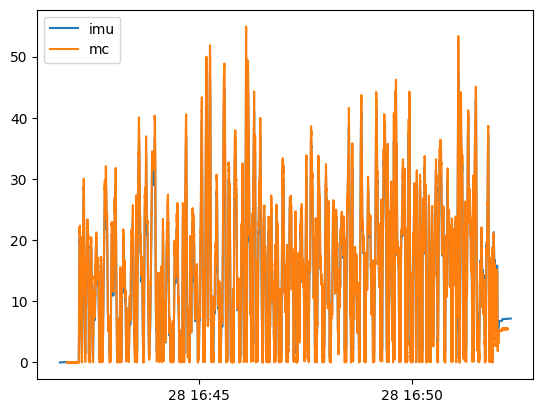

In [37]:
plt.plot(_sk_df.time[:], _imu[:], label="imu")
plt.plot(_m_df["time"][:], abs(_theta_z[:]), label="mc")
plt.legend()